In [2]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [3]:
import tensorflow as tf
tf.__version__

'2.0.0'

In [4]:
import os
import sys
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from random import shuffle

import pickle

from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

%matplotlib inline

In [5]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [6]:
ALL_DATA_DIR = '/home/datasets/yelp/'
data_file=os.path.join(ALL_DATA_DIR,'photo.csv')
data_directory=os.path.join(ALL_DATA_DIR,'photos')

INPUT_SIZE = (224, 224)
#INPUT_SIZE = (299, 299)

In [7]:
if False:
    import cv2
    orig_dir=os.path.join(ALL_DATA_DIR,'photos_orig')
    dst_dir=os.path.join(ALL_DATA_DIR,'photos')
    img_files = os.listdir(orig_dir)
    print(len(img_files))
    for f in log_progress(img_files):
        img = cv2.imread(os.path.join(orig_dir, f))
        cv2.imwrite(os.path.join(dst_dir, f),img)

In [8]:
import pandas as pd
df = pd.read_csv(data_file)

In [9]:
df['photo_id']=df['photo_id']+'.jpg'
df.head()

,photo_id,business_id,label,caption
0,MllA1nNpcp1kDteVg6OGUw.jpg,rcaPajgKOJC2vo_l3xa42A,inside,NaN
1,YjxBE88Bf6CmTEF2LP1UNA.jpg,Kn23LDd740SBVJ7mum0fwg,inside,NaN
2,1f7izSjM0WjkDRIVbPy1yw.jpg,ZkGDCVKSdf8m76cnnalL-A,food,NaN
3,NcSlcDTEEeOaixotOPk-rA.jpg,bF8gv7k_rwZtiDLP2ZB04w,inside,NaN
4,5IiIo5UKEW0lWqZ6sWrY_A.jpg,50Anorn0DJXFhBr9a9_gHQ,inside,NaN


In [9]:
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json
from tensorflow.keras.applications import mobilenet,mobilenet_v2,densenet,inception_resnet_v2,inception_v3,resnet_v2,resnet
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,Activation, Conv2D, Reshape,DepthwiseConv2D,Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, Callback, CSVLogger, EarlyStopping
from tensorflow.keras.metrics import top_k_categorical_accuracy
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from myimage import ImageDataGenerator

In [10]:
INPUT_SIZE = (224, 224)
net_model=mobilenet_v2
#net_description='mobilenet2_alpha=1.4'
#base_model_path='../scenes/places_mobilenet2_alpha=1.4_augm_ft_sgd_model.h5'

net_description='mobilenet2_alpha=1.0'
#base_model_path='../scenes/places_mobilenet2_alpha=1.0_augm_ft_sgd_model.h5'

#net_model=resnet
#net_description='resnet101'
#base_model_path='../scenes/places_resnet_101_augm_ft_sgd.h5'

#net_model=densenet
#net_description='densenet121'
#net_model=mobilenet
#net_description='mobilenet'
#net_model=inception_resnet_v2
#net_description='inception_resnet_v2'

net_model=inception_v3
net_description='inception_v3'
INPUT_SIZE = (299, 299)
#base_model_path='../scenes/places_inception_v3_augm_ft_sgd.h5'

#net_model=resnet_v2
#net_description='resnet2_50'

net_description='yelp_'+net_description

BATCH_SIZE=64 #512 #64 #32 #64

def save_model(model,filename):
    model.save_weights('weights.h5')
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)

    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights('weights.h5')
    loaded_model.save(filename)

In [11]:
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

In [12]:
USE_EFFICENT_NET=True

if USE_EFFICENT_NET:
    import efficientnet.tfkeras as enet

    base_model_path='yelp_enet3_reduced_balanced_multioutput_model_augm_ft_sgd.h5' #None #'yelp_enet3_multioutput_model_augm_ft_sgd.h5'
    base_model = enet.EfficientNetB3(weights=None)
    base_model.load_weights('/home/avsavchenko/distr/efficientnet/efficientnet-b3-weights.h5')

    INPUT_SIZE = base_model.input_shape[1]
    INPUT_SIZE=(INPUT_SIZE,INPUT_SIZE)
    target_size=INPUT_SIZE
    preprocessing_function=enet.preprocess_input
    net_description='enet3_reduced_balanced'
else:
    def random_crop(x, random_crop_size, sync_seed=None, **kwargs):
        np.random.seed(sync_seed)
        w, h = x.shape[1], x.shape[2]
        rangew = (w - random_crop_size[0]) // 2
        rangeh = (h - random_crop_size[1]) // 2
        offsetw = 0 if rangew == 0 else np.random.randint(rangew)
        offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
        return x[:, offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1]]

    preprocessing_function=net_model.preprocess_input
    target_size=INPUT_SIZE
    #preprocessing_function,target_size=my_preprocessing,(256,256)
print(target_size)

(300, 300)


In [13]:
if False:
    train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, 
                                       samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06,
                                       rotation_range=0.1, width_shift_range=-0.1, height_shift_range=-0.1, brightness_range=None, shear_range=0.0, 
                                       zoom_range=0.1, channel_shift_range=1.05, fill_mode='nearest', horizontal_flip=True, vertical_flip=False,
                                       preprocessing_function=preprocessing_function)
    train_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)

    test_datagen = ImageDataGenerator(preprocessing_function=preprocessing_function)
else:
    datagen = ImageDataGenerator(preprocessing_function=preprocessing_function,validation_split=0.1)

# Train for photo labels

In [42]:
val_generator = datagen.flow_from_dataframe(
    dataframe=df, directory=data_directory, x_col='photo_id', y_col='label', subset='validation',
    target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

train_generator = datagen.flow_from_dataframe(
    dataframe=df, directory=data_directory, x_col='photo_id', y_col='label', subset='training',
    target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='categorical',follow_links=True)

Found 20000 validated image filenames belonging to 5 classes.
Found 180000 validated image filenames belonging to 5 classes.


In [43]:
N_CLASS=len(train_generator.class_indices)
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

class_to_idx=val_generator.class_indices
idx_to_class={class_to_idx[cls]:cls for cls in class_to_idx}
print(idx_to_class)

#np.save('idx_to_class.npy',np.array(idx_to_class))

5 180000 20000
{0: 'drink', 1: 'food', 2: 'inside', 3: 'menu', 4: 'outside'}


In [44]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

In [39]:
from tensorflow.keras.layers import LeakyReLU
def create_net(features_only=False, base_model_path=None):
    if base_model_path is not None:
        base_model=load_model(base_model_path)
    else:
        input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3)
        #base_model = mobilenet.MobileNet(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        base_model = mobilenet_v2.MobileNetV2(alpha=1.0, input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        #base_model = inception_v3.InceptionV3(input_shape=input_shape, include_top=True, weights='imagenet')
        #base_model = resnet.ResNet101(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        #base_model = densenet.DenseNet121(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        #base_model = inception_resnet_v2.InceptionResNetV2(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
    #base_model.summary()
    if features_only:
        x=base_model.layers[-2].output
    else:
        x=base_model.output

    #x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(N_CLASS, activation='softmax', use_bias=True,name='preds')(x)
    model=Model(base_model.inputs, x)
    return model,base_model

In [40]:
#net_description='yelp_enet3_multihead'
model,base_model=create_net(features_only=True)
descr=net_description+'_feats'

ValueError: When setting `include_top=True` and loading `imagenet` weights, `input_shape` should be (224, 224, 3).

In [18]:
start_epoch=0

for l in base_model.layers:
    l.trainable=False
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

mc = ModelCheckpoint(descr+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2)
FIRST_EPOCHS=10

print('Head tuning')
hist1=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=FIRST_EPOCHS, verbose=1, 
                    initial_epoch=0, callbacks=[mc, es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

 418/2812 [===>..........................] - ETA: 1:29:13 - loss: 0.2748 - accuracy: 0.9165

KeyboardInterrupt: 

In [83]:
start_epoch=0 #len(hist1.history['loss'])
model.load_weights(descr+'.h5')
for l in base_model.layers:
    l.trainable=True
    
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
SECOND_EPOCHS=5+start_epoch
mc = ModelCheckpoint(descr+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2 )

print('All tuning')
hist2=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=SECOND_EPOCHS, verbose=1, 
                    initial_epoch=start_epoch, callbacks=[mc,es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)


All tuning
Epoch 1/5
2811/2812 [============================>.] - ETA: 0s - loss: 0.1015 - accuracy: 0.9654
Epoch 00001: val_accuracy improved from -inf to 0.95182, saving model to yelp_mobilenet2_alpha=1.0_feats_ft.h5
2812/2812 [==============================] - 1280s 455ms/step - loss: 0.1015 - accuracy: 0.9654 - val_loss: 0.1596 - val_accuracy: 0.9518
Epoch 2/5
2811/2812 [============================>.] - ETA: 0s - loss: 0.0542 - accuracy: 0.9808
Epoch 00002: val_accuracy improved from 0.95182 to 0.96109, saving model to yelp_mobilenet2_alpha=1.0_feats_ft.h5
2812/2812 [==============================] - 1282s 456ms/step - loss: 0.0542 - accuracy: 0.9808 - val_loss: 0.1179 - val_accuracy: 0.9611
Epoch 3/5
2811/2812 [============================>.] - ETA: 0s - loss: 0.0337 - accuracy: 0.9877
Epoch 00003: val_accuracy did not improve from 0.96109
2812/2812 [==============================] - 1288s 458ms/step - loss: 0.0338 - accuracy: 0.9877 - val_loss: 0.1740 - val_accuracy: 0.9505
Epoc

In [84]:
model.load_weights(descr+'_ft.h5')
#model.load_weights(net_description+'_augm_ft_sgd.h5')
model.compile(optimizer=SGD(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
mc = ModelCheckpoint(descr+'_ft_sgd.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2)
second_epoch=start_epoch+len(hist2.history['loss'])
THIRD_EPOCHS=5+second_epoch

hist3=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=THIRD_EPOCHS, verbose=1, 
                    initial_epoch=second_epoch, callbacks=[mc,es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

2811/2812 [============================>.] - ETA: 0s - loss: 0.0235 - accuracy: 0.9929
Epoch 00005: val_accuracy improved from -inf to 0.97035, saving model to yelp_mobilenet2_alpha=1.0_feats_ft_sgd.h5
2812/2812 [==============================] - 1279s 455ms/step - loss: 0.0235 - accuracy: 0.9929 - val_loss: 0.0932 - val_accuracy: 0.9704
Epoch 6/9
2811/2812 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9950
Epoch 00006: val_accuracy improved from 0.97035 to 0.97125, saving model to yelp_mobilenet2_alpha=1.0_feats_ft_sgd.h5
2812/2812 [==============================] - 1274s 453ms/step - loss: 0.0175 - accuracy: 0.9950 - val_loss: 0.0927 - val_accuracy: 0.9713
Epoch 7/9
2811/2812 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9956
Epoch 00007: val_accuracy did not improve from 0.97125
2812/2812 [==============================] - 1272s 452ms/step - loss: 0.0153 - accuracy: 0.9956 - val_loss: 0.0930 - val_accuracy: 0.9711
Epoch 8/9
2811/28

In [85]:
model.load_weights(descr+'_ft_sgd.h5')
model.evaluate_generator(val_generator,nb_validation_samples // BATCH_SIZE)

[0.09368017032139529, 0.9721054]

In [245]:
#featureModel=load_model('lap_inception_v3_feats_ft_sgd.h5') #_ft_sgd
featureModel=load_model('lap_mobilenet2_alpha=1.4_feats_ft_sgd.h5') # #combined_filtered
y_features_val_fc_proba=[]
for class_name in log_progress(os.listdir(val_data_dir)):
    if class_name in class_to_idx:
        class_dir=os.path.join(val_data_dir,class_name)
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith('jpg'):
                img=cv2.imread(os.path.join(class_dir,img_name))
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                img=cv2.resize(img,INPUT_SIZE)
                inp = net_model.preprocess_input(np.expand_dims(img, axis=0).astype(np.float32))
                scores=featureModel.predict(inp)
                y_features_val_fc_proba.append(scores)
    
y_features_val_fc_proba= np.concatenate(y_features_val_fc_proba, axis=0)

In [50]:
print(y_features_val_fc_proba.shape, y_val.shape)
y_features_val_fc=np.argmax(y_features_val_fc_proba,axis=1)
print('total acc=',100.0*(y_val==y_features_val_fc).sum()/len(y_val), compute_accuracy(y_features_val_fc))

(11085, 14) (11085,)
total acc= 61.44339197113216 61.44339197113216


# Classifiers

In [40]:
#_,base_model=create_net(features_only=False, base_model_path=base_model_path)
#base_model=load_model('yelp_enet3_reduced_multioutput_model_augm_ft_sgd_notlast.h5')
base_model=load_model('yelp_enet3_reduced_balanced_multioutput_model_augm_ft_sgd_last.h5')
model=Model(base_model.inputs, [base_model.layers[-2].output,base_model.output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [45]:
img_batch=[]
X_features_val,X_scores_val=[],[]
for filepath in log_progress(val_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,INPUT_SIZE)
    img_batch.append(img)
    if len(img_batch)>=BATCH_SIZE:
        img_batch = np.array(img_batch)
        inp = preprocessing_function(img_batch.astype(np.float32))
        features,scores=model.predict(inp)
        #print(features.shape,scores.shape,batch_x.shape,batch_y.shape)
        X_features_val.append(features)
        #X_scores_val.append(scores)
        img_batch=[]
if len(img_batch)>0:
    img_batch = np.array(img_batch)
    inp = preprocessing_function(img_batch.astype(np.float32))
    features,scores=model.predict(inp)
    #print(features.shape,scores.shape,batch_x.shape,batch_y.shape)
    X_features_val.append(features)
    #X_scores_val.append(scores)
img_batch=[]
    
X_features_val= np.concatenate(X_features_val, axis=0)
#X_scores_val=np.concatenate(X_scores_val, axis=0)
y_val=np.array(val_generator.classes)
print(X_features_val.shape, y_val.shape)

X_features_train,X_scores_train=[],[]
for filepath in log_progress(train_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,INPUT_SIZE)
    img_batch.append(img)
    if len(img_batch)>=BATCH_SIZE:
        img_batch = np.array(img_batch)
        inp = preprocessing_function(img_batch.astype(np.float32))
        features,scores=model.predict(inp)
        #print(features.shape,scores.shape,batch_x.shape,batch_y.shape)
        X_features_train.append(features)
        #X_scores_train.append(scores)
        img_batch=[]
if len(img_batch)>0:
    img_batch = np.array(img_batch)
    inp = preprocessing_function(img_batch.astype(np.float32))
    features,scores=model.predict(inp)
    #print(features.shape,scores.shape,batch_x.shape,batch_y.shape)
    X_features_train.append(features)
    #X_scores_train.append(scores)
img_batch=[]

X_features_train= np.concatenate(X_features_train, axis=0)
#X_scores_train= np.concatenate(X_scores_train, axis=0)
y_train=np.array(train_generator.classes)
print(X_features_train.shape, y_train.shape)

(20000, 1536) (20000,)


(180000, 1536) (180000,)


In [31]:
if False:
    X_features_val,X_scores_val,y_val=[],[],[]
    for ibatch in log_progress(range(nb_validation_samples // BATCH_SIZE)):
        batch_x,batch_y=val_generator.next()
        features,scores=model.predict(batch_x)
        #print(features.shape,scores.shape,batch_x.shape,batch_y.shape)
        X_features_val.append(features)
        X_scores_val.append(scores)
        y_val.extend(batch_y)

    X_features_val= np.concatenate(X_features_val, axis=0)
    X_scores_val=np.concatenate(X_scores_val, axis=0)
    y_val=np.array(y_val)
    print(X_features_val.shape, X_scores_val.shape,y_val.shape)

    X_features_train,X_scores_train,y_train=[],[],[]
    for ibatch in log_progress(range(nb_train_samples // BATCH_SIZE)):
        batch_x,batch_y=train_generator.next()
        features,scores=model.predict(batch_x)
        #print(features.shape,scores.shape,batch_x.shape,batch_y.shape)
        X_features_train.append(features)
        X_scores_train.append(scores)
        y_train.extend(batch_y)

    X_features_train= np.concatenate(X_features_train, axis=0)
    X_scores_train=np.concatenate(X_scores_train, axis=0)
    y_train=np.array(y_train)
    print(X_features_train.shape, X_scores_train.shape,y_train.shape)
    
    y_val=np.argmax(y_val,axis=1)
    y_train=np.argmax(y_train,axis=1)

(19936, 1792) (19936, 1000) (19936, 5)


(179936, 1792) (179936, 1000) (179936, 5)


In [26]:
USE_EFFICIENT_NET=True
if USE_EFFICIENT_NET:
    from efficientnet_tpu import EfficientNet
    ckpt_dir=None
    model_name='efficientnet-b5'
    ckpt_dir='efficientnet-b5-randaug'
    net=EfficientNet(model_name=model_name, ckpt_dir=ckpt_dir)
    
    X_features_val,X_scores_val,y_val=[],[],[]
    for filepath, y in zip(val_generator.filepaths,val_generator.classes):
        try:
            features=net.extract_features(filepath)
            X_features_val.append(features)
            y_val.append(y)
        except Exception as ex:
            print(filepath,ex)

    X_features_val= np.concatenate(X_features_val, axis=0)
    X_scores_val=np.array([])
    y_val=np.array(y_val)
    print(X_features_val.shape, y_val.shape)

    X_features_train,X_scores_train,y_train=[],[],[]
    for filepath, y in zip(train_generator.filepaths,train_generator.classes):
        try:
            features=net.extract_features(filepath)
            X_features_train.append(features)
            y_train.append(y)
        except Exception as ex:
            print(filepath,ex)

    X_features_train= np.concatenate(X_features_train, axis=0)
    X_scores_train=np.array([])
    y_train=np.array(y_train)
    print(X_features_train.shape, X_scores_train.shape,y_train.shape)

(20000, 2048) (20000,)
(180000, 2048) (0,) (180000,)


In [79]:
#print(X_features_train.shape, X_scores_train.shape,y_train.shape)
FEATURES_FILE='yelp_mobilenetv_1.0_features_scores.npz'
#FEATURES_FILE='yelp_mobilenetv_1.4_features_scores.npz'
#FEATURES_FILE='yelp_inception_features_scores.npz'
#FEATURES_FILE='yelp_efficientnet5_features.npz'

In [80]:
np.savez(FEATURES_FILE, X_features_train,X_scores_train,y_train,X_features_val,X_scores_val,y_val,train_generator.filepaths,val_generator.filepaths)

In [34]:
data = np.load(FEATURES_FILE)
X_features_train=data['arr_0']
X_scores_train=data['arr_1']
y_train=data['arr_2'] #np.argmax(data['arr_2'],axis=1)
X_features_val=data['arr_3']
X_scores_val=data['arr_4']
y_val=data['arr_5'] #np.argmax(data['arr_5'],axis=1)
print(X_features_train.shape, X_scores_train.shape,y_train.shape)
print(X_features_val.shape, X_scores_val.shape,y_val.shape)

train_filepaths=data['arr_6']
val_filepaths=data['arr_7']
print(len(train_filepaths),len(val_filepaths))

(180000, 2048) (0,) (180000,)
(20000, 2048) (0,) (20000,)
180000 20000


In [26]:
classifiers=[('rf100',RandomForestClassifier(n_estimators=100)),#('rf1000',RandomForestClassifier(n_estimators=1000)),
             #('erf100',ExtraTreesClassifier(n_estimators=100)),#('erf1000',ExtraTreesClassifier(n_estimators=1000)),
             ('linear svm',LinearSVC()),
             #('Svm (linear)',SVC(kernel='linear',gamma='scale')),
             #('Svm (rbf)',SVC(kernel='rbf',gamma='scale'))
            ]

In [28]:
print('Features')
for cls_name,classifier in classifiers:
    classifier.fit(X_features_train,y_train)
    y_val_pred=classifier.predict(X_features_val)
    acc=100.0*(y_val==y_val_pred).sum()/len(y_val)
    print(cls_name,' acc=',acc)

Features
rf100  acc= 91.925
linear svm  acc= 95.655


/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [77]:
print('Scores')
for cls_name,classifier in classifiers:
    classifier.fit(X_scores_train,y_train)
    y_val_pred=classifier.predict(X_scores_val)
    acc=100.0*(y_val==y_val_pred).sum()/len(y_val)
    print(cls_name,' acc=',acc)

Scores
rf100  acc= 93.74
linear svm  acc= 92.225


In [27]:
#classifiers=[('rf',RandomForestClassifier(n_estimators=100)),('linear svm',LinearSVC())]
print('Normalized features')
for cls_name,classifier in classifiers:
    classifier.fit(preprocessing.normalize(X_features_train,norm='l2'),y_train)
    y_val_pred=classifier.predict(preprocessing.normalize(X_features_val,norm='l2'))
    acc=100.0*(y_val==y_val_pred).sum()/len(y_val)
    print(cls_name,' acc=',acc)

Normalized features
rf100  acc= 91.83
linear svm  acc= 95.71


In [48]:
try:
    del feature_classifier_model
except:
    pass

feature_classifier_model=Sequential()
if False:
    feature_classifier_model.add(Dense(1024, input_shape=X_features_train.shape[1:], activation='relu'))
    #feature_classifier_model.add(LeakyReLU())
    #feature_classifier_model.add(Dropout(0.25))
    feature_classifier_model.add(Dense(N_CLASS, activation='softmax', use_bias=True,name='label_preds'))
else:
    feature_classifier_model.add(Dense(N_CLASS, input_shape=X_features_train.shape[1:], activation='softmax', use_bias=True,name='label_preds'))

feature_classifier_model.compile(optimizer=Adam(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
feature_classifier_model.summary()

es=EarlyStopping(monitor='val_accuracy',patience=2)
#mc = ModelCheckpoint(OBJECT_CLASSIFIER_NAME, monitor='val_acc', verbose=1, save_best_only=True)
                
feature_classifier_model.fit(X_features_train,y_train, batch_size=128, epochs=12, verbose=1, callbacks=[es], validation_data=(X_features_val,y_val)) #,class_weight=class_weights)
#feature_classifier_model.fit([X_features_train,X_scores_train],y_train, batch_size=64, epochs=10, verbose=1, callbacks=[es], validation_data=([X_features_val,X_scores_val],y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
label_preds (Dense)          (None, 5)                 7685      
Total params: 7,685
Trainable params: 7,685
Non-trainable params: 0
_________________________________________________________________
Train on 180000 samples, validate on 20000 samples
Epoch 1/12
180000/180000 [==============================] - 3s 18us/sample - loss: 0.1944 - accuracy: 0.9420 - val_loss: 0.1600 - val_accuracy: 0.9462
Epoch 2/12
180000/180000 [==============================] - 3s 17us/sample - loss: 0.1225 - accuracy: 0.9589 - val_loss: 0.1472 - val_accuracy: 0.9492
Epoch 3/12
180000/180000 [==============================] - 3s 17us/sample - loss: 0.1131 - accuracy: 0.9616 - val_loss: 0.1419 - val_accuracy: 0.9508
Epoch 4/12
180000/180000 [==============================] - 3s 17us/sample - loss: 0.1082 - accuracy: 0.9631 - val_loss: 0.1405 - val_accuracy

In [49]:
feature_classifier_model.compile(optimizer=SGD(lr=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

feature_classifier_model.fit(X_features_train,y_train, batch_size=128, epochs=2, verbose=1, validation_data=(X_features_val,y_val))

Train on 180000 samples, validate on 20000 samples
Epoch 1/2
180000/180000 [==============================] - 3s 18us/sample - loss: 0.0928 - accuracy: 0.9684 - val_loss: 0.1358 - val_accuracy: 0.9530
Epoch 2/2
180000/180000 [==============================] - 3s 17us/sample - loss: 0.0927 - accuracy: 0.9683 - val_loss: 0.1357 - val_accuracy: 0.9530


Mobilenet v2 1.0
Epoch 00002: val_accuracy improved from 0.90405 to 0.90685, saving model to yelp_mobilenet2_alpha=1.0_feats.h5
2812/2812 [==============================] - 2043s 727ms/step - loss: 0.1471 - accuracy: 0.9496 - val_loss: 0.3529 - val_accuracy: 0.9069

Epoch 00008: val_accuracy improved from 0.97125 to 0.97211, saving model to yelp_mobilenet2_alpha=1.0_feats_ft_sgd.h5
2812/2812 [==============================] - 1272s 452ms/step - loss: 0.0133 - accuracy: 0.9960 - val_loss: 0.0937 - val_accuracy: 0.9721

Features
rf100  acc= 93.805
linear svm  acc= 95.37

Scores
rf100  acc= 93.74
linear svm  acc= 92.225

Normalized features
rf100  acc= 93.925
linear svm  acc= 95.78


Mobilenet v2 1.4
Epoch 00003: val_accuracy improved from 0.90039 to 0.91877, saving model to yelp_mobilenet2_alpha=1.4_feats.h5
2812/2812 [==============================] - 1409s 501ms/step - loss: 0.1347 - accuracy: 0.9533 - val_loss: 0.3429 - val_accuracy: 0.9188

Epoch 00002: val_accuracy improved from 0.95868 to 0.96129, saving model to yelp_mobilenet2_alpha=1.4_feats_ft.h5
2812/2812 [==============================] - 1617s 575ms/step - loss: 0.0568 - accuracy: 0.9800 - val_loss: 0.1345 - val_accuracy: 0.9613

Normalized features
rf100  acc= 93.545
linear svm  acc= 96.19


Inception
Epoch 00005: val_accuracy improved from 0.91501 to 0.92458, saving model to yelp_inception_v3_feats.h5
2812/2812 [==============================] - 2026s 721ms/step - loss: 0.1273 - accuracy: 0.9564 - val_loss: 0.2971 - val_accuracy: 0.9246

All tuning
Epoch 00004: val_accuracy improved from 0.96499 to 0.96620, saving model to yelp_inception_v3_feats_ft.h5
2812/2812 [==============================] - 2419s 860ms/step - loss: 0.0274 - accuracy: 0.9902 - val_loss: 0.1226 - val_accuracy: 0.9662
SGD:
val accuracy: 0.9715044

Scores
linear svm  acc= 90.69

Normalized features
rf100  acc= 94.17
linear svm  acc= 96.15


EfficientNet v5
Normalized features
rf100  acc= 94.855
linear svm  acc= 96.73

yelp_enet0_multioutput_model_augm_ft_sgd
Features
rf100  acc= 91.925
linear svm  acc= 95.655

Normalized features
rf100  acc= 91.83
linear svm  acc= 95.71

## Add classifier to multioutput model

In [50]:
#Results per category
classifier=LinearSVC()
if False:
    classifier.fit(preprocessing.normalize(X_features_train,norm='l2'),y_train)
    y_val_pred=classifier.predict(preprocessing.normalize(X_features_val,norm='l2'))
else:
    classifier.fit(X_features_train,y_train)
    y_val_pred=classifier.predict(X_features_val)

/usr/local/lib/python3.5/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [51]:
print('total acc=',100.0*(y_val==y_val_pred).sum()/len(y_val))

total acc= 95.37


In [57]:
y_labels=np.unique(y_val)
label2acc={}
for y_label in y_labels:
    y_pred=y_val_pred[y_val==y_label]
    acc=100.0*(y_label==y_pred).sum()/len(y_pred)
    label2acc[idx_to_class[y_label]]=(acc,len(y_pred))

for key, value in sorted(label2acc.items(), key=lambda kv: (kv[1][0],(kv[0],kv[1][1])),reverse=True):
    print (key, value[1], value[0])

food 9860 97.89046653144017
inside 6469 96.2436234348431
outside 1806 89.09191583610188
menu 242 88.4297520661157
drink 1623 88.17005545286507


In [52]:
from tensorflow.keras.layers import Flatten, Dense, Dropout,GlobalAveragePooling2D,AveragePooling2D, Activation, Conv2D, Lambda, Input, Reshape
from tensorflow.keras import backend as K

layer=base_model.layers[-2].output
print(layer)
if False:
    #l2_norm = Lambda(lambda  x: K.l2_normalize(x,axis=1))(layer)
    l2_norm=layer
    label_scores = Dense(N_CLASS,weights=[classifier.coef_.T,classifier.intercept_],name='label_fc')(l2_norm)
else:
    label_scores = Dense(N_CLASS,weights=feature_classifier_model.layers[0].get_weights(),activation='softmax',name='label_fc')(layer)
    #label_scores=Activation('softmax',name='label_fc')(label_scores)
    
new_model=Model(base_model.inputs, [base_model.output,label_scores])
new_model.summary()

Tensor("top_dropout_4/Identity:0", shape=(None, 1536), dtype=float32)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
______________________

block5e_project_conv (Conv2D)   (None, 19, 19, 136)  110976      block5e_se_excite[0][0]          
__________________________________________________________________________________________________
block5e_project_bn (BatchNormal (None, 19, 19, 136)  544         block5e_project_conv[0][0]       
__________________________________________________________________________________________________
block5e_drop (FixedDropout)     (None, 19, 19, 136)  0           block5e_project_bn[0][0]         
__________________________________________________________________________________________________
block5e_add (Add)               (None, 19, 19, 136)  0           block5e_drop[0][0]               
                                                                 block5d_add[0][0]                
__________________________________________________________________________________________________
block6a_expand_conv (Conv2D)    (None, 19, 19, 816)  110976      block5e_add[0][0]                
__________

In [53]:
MODEL_PATH='enet3_multihead_model_balanced'
preprocessing_function=enet.preprocess_input

In [54]:
save_model(new_model,MODEL_PATH+'.h5')

In [55]:
print(new_model.output)
outputs=[o.op.name for o in new_model.output]
print (outputs)
print(new_model.predict(preprocessing_function(np.ones((1,300,300,3)))))

[<tf.Tensor 'dense_4/Identity:0' shape=(None, 15) dtype=float32>, <tf.Tensor 'label_fc/Identity:0' shape=(None, 5) dtype=float32>]
['dense_4/Identity', 'label_fc/Identity']
[array([[0.03631079, 0.06637004, 0.0907115 , 0.027706  , 0.05302593,
        0.10339746, 0.03904057, 0.16787484, 0.08069381, 0.03452772,
        0.09296021, 0.07938898, 0.05114393, 0.06180146, 0.10978857]],
      dtype=float32), array([[0.08033161, 0.15053856, 0.7262663 , 0.01927829, 0.02358526]],
      dtype=float32)]


In [77]:
tf.compat.v1.reset_default_graph()
model=load_model(MODEL_PATH+'.h5')

_,w,h,_=model.input_shape
print(w,h)

outputs=[o.op.name for o in model.output]
print (outputs)
   
model.summary()

224 224
['dense_14/Identity', 'label_fc_16/Identity']
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________

In [48]:
total,correct=0,0
for y,filepath in zip(val_generator.classes,val_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(w,h))
    total+=1
    #inp = np.expand_dims(img, axis=0).astype(np.float32)/127.5 - 1.
    inp = preprocessing_function(np.expand_dims(img, axis=0).astype(np.float32))
    preds_restaurants,preds_labels = model.predict(inp)
    #print(preds_restaurants,preds_labels)
    #print(preds_restaurants.shape,preds_labels.shape)
    y_pred=preds_labels[0].argmax()
    if y==y_pred:
        correct+=1

print(100.*correct/total,correct,total)

95.71 19142 20000


# Scenes

In [13]:
dir_path = os.getcwd()
new_sys_dir = os.path.join(dir_path,'..')
if not new_sys_dir in sys.path:
    sys.path.append(new_sys_dir)

In [22]:
from scenes.scene_analysis import  get_scene_recognizer,get_scene2files

In [23]:
sceneProcessing=get_scene_recognizer(mostAccurate=True)

[]
[]
Tensor("dense_1/Softmax:0", shape=(None, 431), dtype=float32)
Tensor("event_fc/BiasAdd:0", shape=(None, 82), dtype=float32)
Tensor("input_1:0", shape=(None, 299, 299, 3), dtype=float32) 299 299


In [32]:
file2scene_val=[{} for _ in range(N_CLASS)]
#for filepath,y in tqdm(zip(val_generator.filepaths,val_generator.classes),total=len(val_generator.classes)):
for filepath,y in zip(log_progress(val_generator.filepaths),val_generator.classes):
    img=cv2.imread(filepath)
    image_np = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    output_scene=sceneProcessing.scenes_func(image_np)
    file2scene_val[y][filepath]=(output_scene[0][0],output_scene[1][0])

drink
bar:[971]
beer hall:[603]
coffee shop:[355]
restaurant:[241]
ice cream parlor:[108]
pub:[45]
beer garden:[33]
chemistry lab:[30]
candy store:[22]
pharmacy:[20]
bakery shop:[20]
food
restaurant:[4895]
bakery shop:[4175]
delicatessen:[3207]
pizza:[2175]
ice cream parlor:[764]
birthday:[659]
butchers shop:[561]
coffee shop:[433]
candy store:[360]
wedding:[162]
florist shop:[142]
supermarket:[116]
fastfood restaurant:[106]
picnic:[90]
market:[88]
cheese factory:[69]
restaurant kitchen:[68]
sushi bar:[59]
bar:[58]
dining car:[52]
vegetable garden:[47]
beer hall:[31]
kindergarden classroom:[27]
spa:[25]
aquarium:[20]
inside
restaurant:[2199]
bar:[1449]
dining hall:[920]
beer hall:[596]
banquet hall:[485]
sushi bar:[471]
pub:[452]
discotheque:[304]
coffee shop:[292]
lobby:[271]
fastfood restaurant:[247]
dining room:[206]
food court:[203]
birthday:[169]
restaurant kitchen:[160]
bakery shop:[153]
meeting:[130]
delicatessen:[99]
stage:[92]
ice cream parlor:[83]
music studio:[82]
pizza:[77]

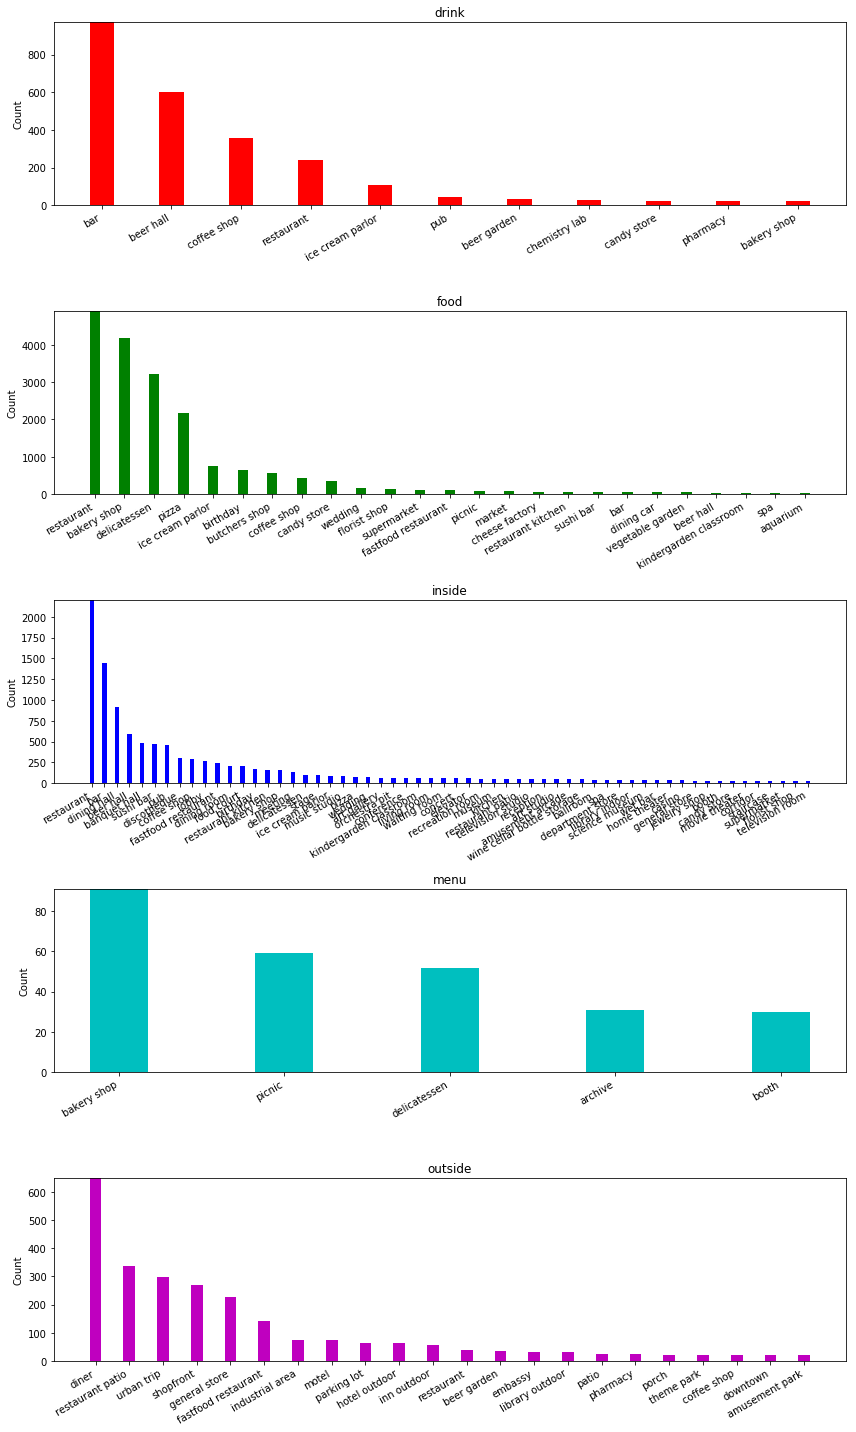

In [42]:
from collections import OrderedDict
width = 0.35       # the width of the bars
plt_w,plt_h=12,4
fig, axes = plt.subplots(len(file2scene_val),1, figsize=(plt_w,plt_h*len(file2scene_val)), squeeze=False)
colors=['r','g','b','c','m']
min_scenes_count=20
for i,file2scene in enumerate(file2scene_val):
    scene2files=get_scene2files(sceneProcessing, file2scene, ALL_DATA_DIR,  save_events=False)
    scene2count={scene:len(files) for scene,files in scene2files.items() if len(files)>=min_scenes_count}
    scene2count=OrderedDict(sorted(scene2count.items(), key=lambda item: -item[1]))
    title=idx_to_class[i]
    
    ax=axes[i, 0]
    #plot histo
    print(title)
    for scene in scene2count:
        print('%s:[%d]'%(scene,scene2count[scene]))

    ind = np.arange(len(scene2count))
    bars=ax.bar(ind,scene2count.values(),width,color=colors[i%len(colors)])
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(scene2count.keys())
    ax.set_ylim([0, 1 if len(scene2count)==0 else max(scene2count.values())])
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(30)

plt.tight_layout()
plt.show()

In [43]:
file2scene_train=[{} for _ in range(N_CLASS)]
for filepath,y in zip(log_progress(train_generator.filepaths),train_generator.classes):
    img=cv2.imread(filepath)
    image_np = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    output_scene=sceneProcessing.scenes_func(image_np)
    file2scene_train[y][filepath]=(output_scene[0][0],output_scene[1][0])

drink
bar:[8217]
beer hall:[6293]
coffee shop:[5072]
restaurant:[2333]
ice cream parlor:[1111]
beer garden:[731]
teashop:[352]
candy store:[235]
spa:[226]
chemistry lab:[223]
pub:[221]
bakery shop:[205]
birthday:[188]
pantry:[174]
supermarket:[167]
florist shop:[163]
pharmacy:[150]
general store:[148]
vegetable garden:[130]
wine cellar bottle storage:[130]
kindergarden classroom:[110]
discotheque:[91]
restaurant patio:[85]
sushi bar:[80]
art studio:[80]
wedding:[73]
delicatessen:[68]
cheese factory:[54]
beauty salon:[52]
restaurant kitchen:[46]
museum:[44]
playroom:[43]
science museum:[32]
booth:[31]
department store:[30]
dining hall:[30]
physics laboratory:[29]
food court:[28]
Oktoberfest:[27]
bathroom:[26]
balcony:[25]
wine cellar barrel storage:[25]
music studio:[25]
pizza:[22]
amusement arcade:[22]
bowling alley:[22]
kitchen:[22]
jewelry shop:[21]
aquarium:[20]
biology laboratory:[20]
food
bakery shop:[53977]
restaurant:[38859]
delicatessen:[31418]
pizza:[23458]
ice cream parlor:[7

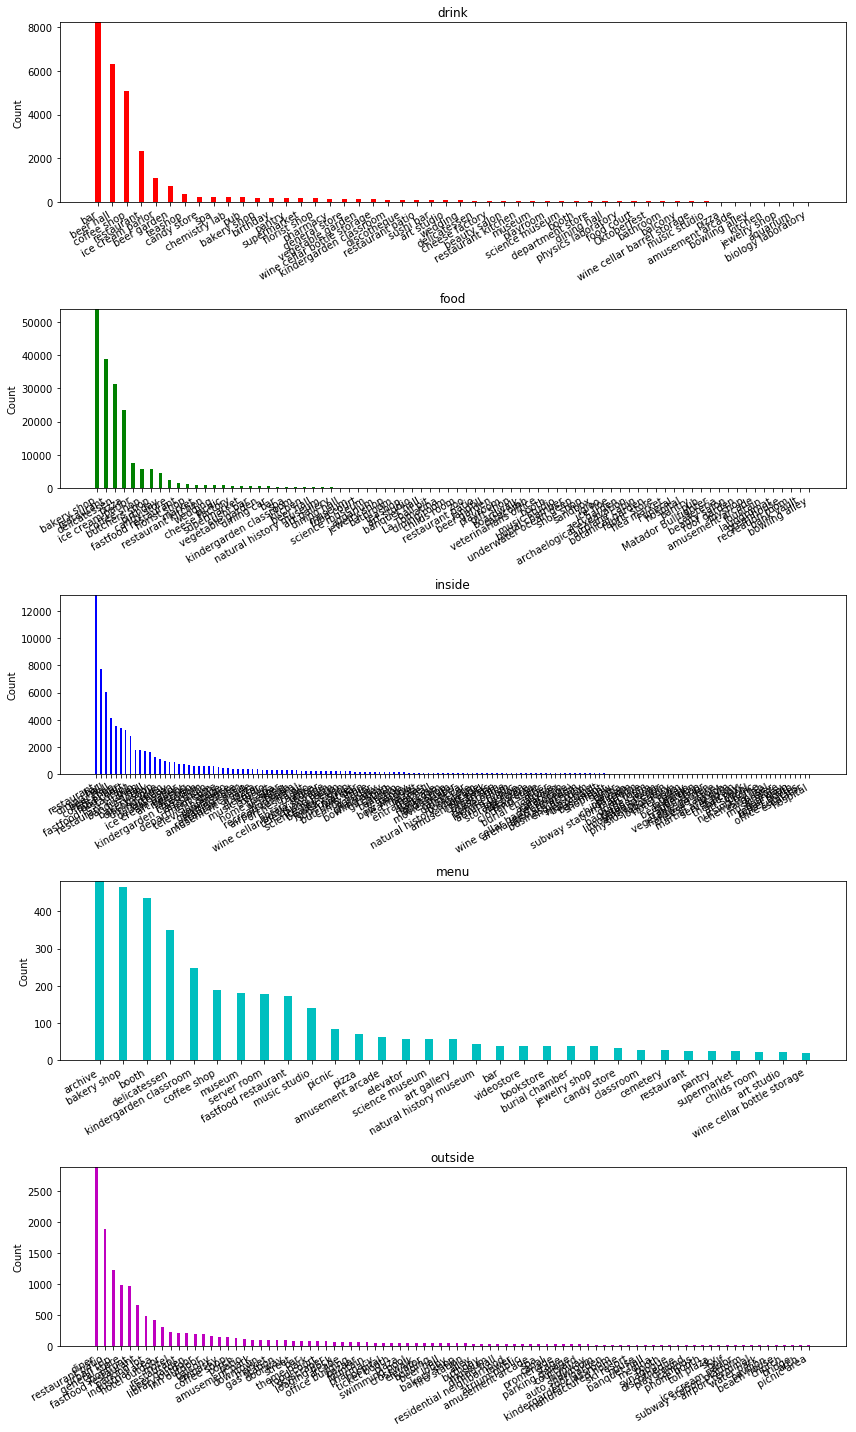

In [44]:
from collections import OrderedDict
width = 0.35       # the width of the bars
plt_w,plt_h=12,4
fig, axes = plt.subplots(len(file2scene_train),1, figsize=(plt_w,plt_h*len(file2scene_train)), squeeze=False)
colors=['r','g','b','c','m']
min_scenes_count=20
for i,file2scene in enumerate(file2scene_train):
    scene2files=get_scene2files(sceneProcessing, file2scene, ALL_DATA_DIR, save_events=False)
    scene2count={scene:len(files) for scene,files in scene2files.items() if len(files)>=min_scenes_count}
    scene2count=OrderedDict(sorted(scene2count.items(), key=lambda item: -item[1]))
    title=idx_to_class[i]
    
    ax=axes[i, 0]
    #plot histo
    print(title)
    for scene in scene2count:
        print('%s:[%d]'%(scene,scene2count[scene]))

    ind = np.arange(len(scene2count))
    bars=ax.bar(ind,scene2count.values(),width,color=colors[i%len(colors)])
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.set_xticks(ind)
    ax.set_xticklabels(scene2count.keys())
    ax.set_ylim([0, 1 if len(scene2count)==0 else max(scene2count.values())])
    for label in ax.get_xticklabels():
        label.set_ha("right")
        label.set_rotation(30)

plt.tight_layout()
plt.show()

In [54]:
YELP_SCENES=['archive','bakery shop','bar','beer hall','beer garden','cafeteria','coffee shop','delicatessen',
             'diner','dining room','fastfood restaurant','food court','general store','ice cream parlor','picnic','pizza','pub',
             'restaurant','restaurant kitchen','restaurant patio','shopfront','supermarket','sushi bar','wet bar','Oktoberfest']

drink 1487 1623 136 0.9162045594577942
food 9282 9860 578 0.9413793103448276
inside 4674 6469 1795 0.7225228010511671
menu 153 242 89 0.6322314049586777
outside 1181 1806 625 0.6539313399778516
16777 20000 0.83885


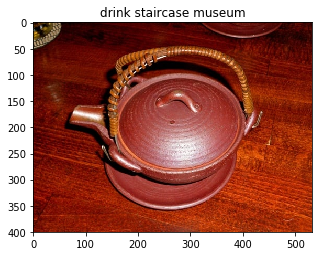

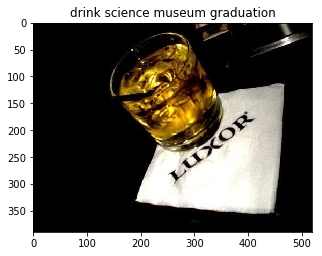

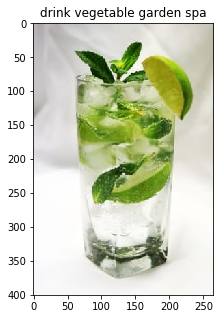

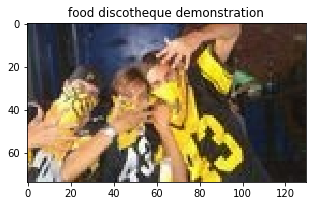

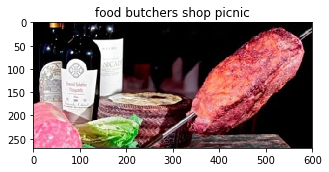

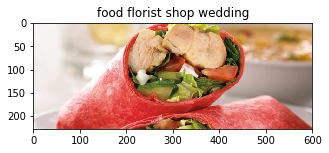

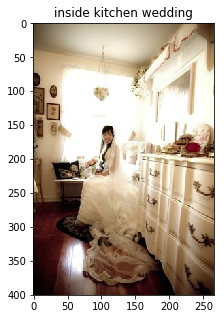

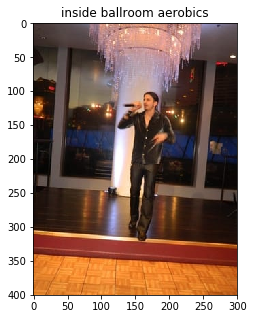

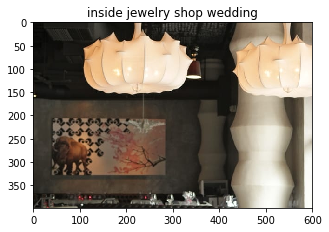

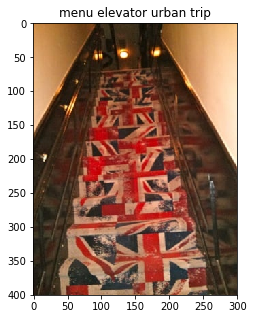

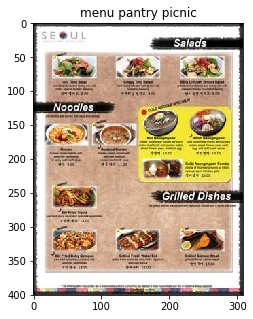

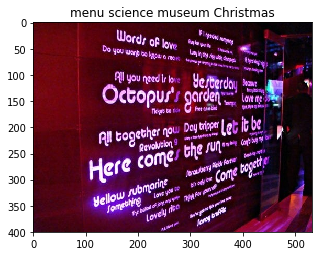

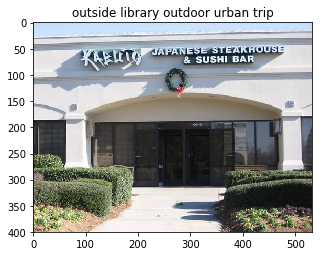

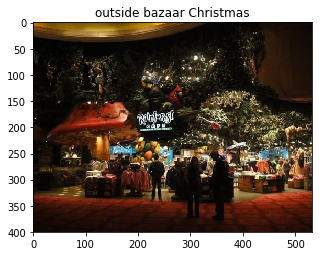

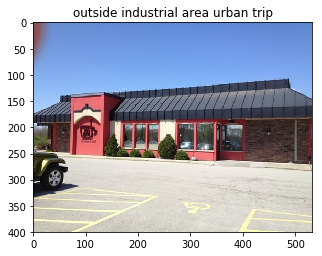

In [69]:
import random
recognized_scenes_all=set()
for i,file2scene in enumerate(file2scene_val):
    scene2files=get_scene2files(sceneProcessing, file2scene, ALL_DATA_DIR, save_events=False)
    recognized_scenes=set()
    for scene in YELP_SCENES:
        if scene in scene2files:
            recognized_scenes|=scene2files[scene]
    recognized_scenes_all|=recognized_scenes
    unrecognized_scenes=set(file2scene.keys())-recognized_scenes
    print(idx_to_class[i],len(recognized_scenes),len(file2scene), len(unrecognized_scenes),len(recognized_scenes)/len(file2scene))
    if True:
        for _ in range(3):
            image_path=random.choice(list(unrecognized_scenes))
            plt.figure(figsize=(5, 5))
            img=cv2.imread(image_path)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            descr=idx_to_class[i]+' '+sceneProcessing.all_labels[np.argmax(file2scene[image_path][0])]+' '+sceneProcessing.event_all_labels[np.argmax(file2scene[image_path][1])]
            plt.title(descr)

print(len(recognized_scenes_all),len(val_generator.classes), len(recognized_scenes_all)/len(val_generator.classes))
plt.show()

In [56]:
recognized_scenes_all=set()
for i,file2scene in enumerate(file2scene_train):
    scene2files=get_scene2files(sceneProcessing, file2scene, ALL_DATA_DIR, save_events=False)
    recognized_scenes=set()
    for scene in YELP_SCENES:
        if scene in scene2files:
            recognized_scenes|=scene2files[scene]
    print(idx_to_class[i],len(recognized_scenes),len(file2scene), len(recognized_scenes)/len(file2scene))
    recognized_scenes_all|=recognized_scenes

print(len(recognized_scenes_all),len(train_generator.classes), len(recognized_scenes_all)/len(train_generator.classes))

drink 15019 16498 0.9103527700327313
food 99171 105014 0.9443597996457616
inside 32234 45979 0.7010591791905
menu 1423 2781 0.5116864437252787
outside 5721 9728 0.5880962171052632
153568 180000 0.8531555555555556


In [70]:
sceneProcessing.close()

# Analyze businesses

In [10]:
business_file=os.path.join(ALL_DATA_DIR,'business.csv')
business_df = pd.read_csv(business_file)
print(business_df.columns)
business_df.head()

Index(['attributes.RestaurantsDelivery', 'attributes.Open24Hours',
       'attributes.DogsAllowed', 'attributes.CoatCheck', 'postal_code',
       'attributes.DietaryRestrictions', 'city', 'attributes.GoodForKids',
       'attributes.BYOB', 'attributes.AgesAllowed', 'stars', 'latitude',
       'attributes.Alcohol', 'attributes.RestaurantsPriceRange2',
       'attributes.RestaurantsTableService', 'attributes.HairSpecializesIn',
       'business_id', 'attributes.RestaurantsCounterService',
       'attributes.Corkage', 'attributes.RestaurantsGoodForGroups',
       'categories', 'name', 'attributes.BusinessAcceptsBitcoin',
       'attributes.HappyHour', 'attributes.WheelchairAccessible',
       'attributes.BusinessAcceptsCreditCards', 'attributes.BYOBCorkage',
       'is_open', 'address', 'attributes.Ambience', 'longitude',
       'attributes.BestNights', 'review_count', 'attributes.ByAppointmentOnly',
       'attributes.NoiseLevel', 'state', 'attributes.DriveThru',
       'attributes.HasTV

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,8,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,attributes.RestaurantsDelivery,attributes.Open24Hours,attributes.DogsAllowed,attributes.CoatCheck,postal_code,attributes.DietaryRestrictions,city,attributes.GoodForKids,attributes.BYOB,attributes.AgesAllowed,...,attributes.RestaurantsAttire,attributes.Smoking,attributes.GoodForMeal,attributes.GoodForDancing,attributes.Caters,attributes.AcceptsInsurance,attributes.RestaurantsReservations,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,NaN,NaN,NaN,NaN,85016,NaN,Phoenix,False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,False,NaN,NaN,NaN,L5R 3E7,NaN,Mississauga,True,NaN,NaN,...,u'casual',NaN,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,True,NaN,True,True,False,False
2,False,NaN,NaN,NaN,28210,NaN,Charlotte,True,NaN,NaN,...,'casual',NaN,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,False,NaN,True,True,True,False
3,NaN,NaN,NaN,NaN,85338,NaN,Goodyear,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,28217,NaN,Charlotte,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Train for restaurant categories

In [11]:
category2count={}
all_cats_df=business_df['categories'].dropna()
restaurant_categories=['Restaurants','Cafes']

num_restaurants=0
for categories in all_cats_df:
    categories_split=categories.split(', ')
    if any((True for x in restaurant_categories if x in categories)):
        num_restaurants+=1
        for category in categories_split:
            if category not in category2count:
                category2count[category]=0
            category2count[category]+=1

print(num_restaurants,len(all_cats_df))
print([(key,value) for key, value in sorted(category2count.items(), key=lambda kv: (kv[1],kv[0]),reverse=True)])

59446 192127
[('Restaurants', 59371), ('Food', 14875), ('Nightlife', 8574), ('Bars', 8187), ('Sandwiches', 7332), ('Fast Food', 7257), ('American (Traditional)', 7107), ('Pizza', 6804), ('Burgers', 5404), ('Breakfast & Brunch', 5381), ('American (New)', 4882), ('Italian', 4716), ('Mexican', 4618), ('Chinese', 4428), ('Coffee & Tea', 3692), ('Cafes', 3232), ('Japanese', 2716), ('Chicken Wings', 2705), ('Event Planning & Services', 2690), ('Salad', 2531), ('Seafood', 2508), ('Sushi Bars', 2258), ('Specialty Food', 2093), ('Delis', 1955), ('Asian Fusion', 1953), ('Canadian (New)', 1909), ('Bakeries', 1840), ('Mediterranean', 1834), ('Caterers', 1829), ('Barbeque', 1814), ('Sports Bars', 1811), ('Desserts', 1730), ('Steakhouses', 1603), ('Pubs', 1492), ('Indian', 1489), ('Thai', 1449), ('Diners', 1433), ('Middle Eastern', 1317), ('Vietnamese', 1286), ('Wine & Spirits', 1136), ('Beer', 1136), ('Vegetarian', 1123), ('Greek', 1086), ('Arts & Entertainment', 1056), ('French', 1027), ('Ice Crea

In [12]:
#'Bars','Burgers',
#our_categories=[ 'Sandwiches', 'Fast Food', 'American (Traditional)', 'Pizza',  'Breakfast & Brunch', 'American (New)', 'Italian', 'Mexican', 'Chinese', 'Coffee & Tea', 'Japanese', 'Chicken Wings', 'Salad', 'Seafood', 'Sushi Bars', 'Specialty Food', 'Delis', 'Asian Fusion', 'Canadian (New)', 'Bakeries', 'Mediterranean','Indian']#, 'Caterers', 'Barbeque', 'Sports Bars', 'Desserts', 'Steakhouses', 'Pubs', 'Thai', 'Diners', 'Middle Eastern', 'Vietnamese', 'Wine & Spirits', 'Beer', 'Vegetarian', 'Greek', 'French', 'Ice Cream & Frozen Yogurt', 'Cocktail Bars', 'Wine Bars', 'Korean', 'Juice Bars & Smoothies', 'Buffets', 'Ethnic Food', 'Comfort Food', 'Gluten-Free', 'Vegan']#, 'Soup', 'Hot Dogs', 'Tex-Mex', 'Caribbean', 'Halal', 'Latin American', 'Southern', 'Tapas/Small Plates', 'Pakistani', 'Noodles', 'Bagels', 'Tapas Bars', 'Beer Bar', 'Hawaiian', 'Fish & Chips', 'Donuts', 'Soul Food']
our_categories=[ 'Sandwiches', 'Fast Food', 'American (Traditional)', 'Pizza',  'Breakfast & Brunch', 'American (New)', 'Italian', 'Mexican', 'Chinese', 'Coffee & Tea', 'Japanese', 'Seafood', 'Sushi Bars', 'Asian Fusion', 'Canadian (New)']
category2count={}
for categories in all_cats_df:
    categories_split=categories.split(', ')
    for category in categories_split:
        if category in our_categories:
            if category not in category2count:
                category2count[category]=0
            category2count[category]+=1
print([(key,value) for key, value in sorted(category2count.items(), key=lambda kv: (kv[1],kv[0]),reverse=True)])

[('Sandwiches', 7332), ('Coffee & Tea', 7321), ('Fast Food', 7257), ('American (Traditional)', 7107), ('Pizza', 6804), ('Breakfast & Brunch', 5381), ('American (New)', 4882), ('Italian', 4716), ('Mexican', 4618), ('Chinese', 4428), ('Japanese', 2716), ('Seafood', 2508), ('Sushi Bars', 2258), ('Asian Fusion', 1953), ('Canadian (New)', 1909)]


In [13]:
restaurants_df=business_df[['business_id','categories','name','city', 'latitude','longitude','stars']].dropna()
restaurants_df['categories']=restaurants_df['categories'].str.split(', ')
mask = restaurants_df.categories.apply(lambda x: any(item for item in our_categories if item in x))
restaurants_df=restaurants_df[mask]
print(len(restaurants_df))
#for our_category in our_categories:
#    restaurants_df[our_category] = restaurants_df.apply(lambda row: our_category in row[1],axis=1)
#restaurants_df[[our_categories]] = restaurants_df.apply(lambda row: [our_category in row[1] for our_category in our_categories],axis=1)

newcols = restaurants_df.apply(lambda row: pd.Series([1 if our_category in row[1] else 0 for our_category in our_categories]),axis=1)
newcols.columns = our_categories
#newcols.head()
restaurants_df = restaurants_df.join(newcols) 
restaurants_df.head()

48489


,business_id,categories,name,city,latitude,longitude,stars,Sandwiches,Fast Food,American (Traditional),...,American (New),Italian,Mexican,Chinese,Coffee & Tea,Japanese,Seafood,Sushi Bars,Asian Fusion,Canadian (New)
1,QXAEGFB4oINsVuTFxEYKFQ,"[Specialty Food, Restaurants, Dim Sum, Importe...",Emerald Chinese Restaurant,Mississauga,43.605499,-79.652289,2.5,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,gnKjwL_1w79qoiV3IC_xQQ,"[Sushi Bars, Restaurants, Japanese]",Musashi Japanese Restaurant,Charlotte,35.092564,-80.859132,4.0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
11,1Dfx3zM-rW4n-31KeC8sJg,"[Restaurants, Breakfast & Brunch, Mexican, Tac...",Taco Bell,Phoenix,33.495194,-112.028588,3.0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
13,fweCYi8FmbJXHCqLnwuk8w,"[Italian, Restaurants, Pizza, Chicken Wings]",Marco's Pizza,Mentor-on-the-Lake,41.708520,-81.359556,4.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
17,PZ-LZzSlhSe9utkQYU8pFg,"[Restaurants, Italian]",Carluccio's Tivoli Gardens,Las Vegas,36.100016,-115.128528,4.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [18]:
restaurants_df.to_csv('restaurants.gz', compression='gzip')
cuisine_labels=np.array(restaurants_df[our_categories])
print(cuisine_labels.shape,cuisine_labels)

(48489, 15) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
business_photo_df=df.join(restaurants_df.set_index('business_id'), on='business_id', how='inner')
print(len(df), len(restaurants_df), len(business_photo_df))
business_photo_df.head()

200000 48489 161638


,photo_id,business_id,label,caption,categories,name,city,latitude,longitude,stars,...,American (New),Italian,Mexican,Chinese,Coffee & Tea,Japanese,Seafood,Sushi Bars,Asian Fusion,Canadian (New)
0,MllA1nNpcp1kDteVg6OGUw.jpg,rcaPajgKOJC2vo_l3xa42A,inside,NaN,"[French, Bars, Cocktail Bars, Nightlife, Break...",Bouchon,Las Vegas,36.120955,-115.169853,4.0,...,0,0,0,0,0,0,0,0,0,0
30,-8vsof7QTBM_eb8bONG6uQ.jpg,rcaPajgKOJC2vo_l3xa42A,inside,NaN,"[French, Bars, Cocktail Bars, Nightlife, Break...",Bouchon,Las Vegas,36.120955,-115.169853,4.0,...,0,0,0,0,0,0,0,0,0,0
147,8bITdFwTRU6IaqY04Ij-3g.jpg,rcaPajgKOJC2vo_l3xa42A,food,Poitrine de Veau (Slow Cooked Veil) $29.50,"[French, Bars, Cocktail Bars, Nightlife, Break...",Bouchon,Las Vegas,36.120955,-115.169853,4.0,...,0,0,0,0,0,0,0,0,0,0
148,SCqix5R76QSnWvEF-ut3YA.jpg,rcaPajgKOJC2vo_l3xa42A,drink,Bouchon Coffee,"[French, Bars, Cocktail Bars, Nightlife, Break...",Bouchon,Las Vegas,36.120955,-115.169853,4.0,...,0,0,0,0,0,0,0,0,0,0
263,tT55LOeWKCOwRJ04x9ueEw.jpg,rcaPajgKOJC2vo_l3xa42A,inside,NaN,"[French, Bars, Cocktail Bars, Nightlife, Break...",Bouchon,Las Vegas,36.120955,-115.169853,4.0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
import gc
del val_generator
del train_generator
gc.collect()

802

In [19]:
BATCH_SIZE=16 #64 #12
val_generator = datagen.flow_from_dataframe(
    dataframe=business_photo_df, directory=data_directory, x_col='photo_id', y_col=our_categories, subset='validation',
    target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='raw',follow_links=True)

train_generator = datagen.flow_from_dataframe(
    dataframe=business_photo_df, directory=data_directory, x_col='photo_id', y_col=our_categories, subset='training',
    target_size=target_size,
    batch_size=BATCH_SIZE, class_mode='raw',follow_links=True)

Found 16163 validated image filenames.
Found 145475 validated image filenames.


In [20]:
N_CLASS=len(our_categories)
nb_train_samples=train_generator.samples
nb_validation_samples=val_generator.samples
print(N_CLASS,nb_train_samples,nb_validation_samples)

15 145475 16163


In [21]:
cw=len(train_generator.labels)/np.sum(train_generator.labels,axis=0)
print(cw,cw/cw.min())

[ 7.85459748  7.5274242   5.08227362  9.88012768  5.2846193   5.3416685
  9.69897993 10.90598995 12.38401294  8.97827563  8.51777036 10.62171437
 12.20427852 11.84071301 20.22452384] [1.5454889  1.48111353 1.         1.94403695 1.03981401 1.05103914
 1.90839389 2.145888   2.43670724 1.76658643 1.67597635 2.08995327
 2.40134228 2.32980628 3.97942444]


In [22]:
#cw=len(train_generator.labels)/np.sum(train_generator.labels,axis=0)
cw/=cw.min()
class_weights = {i:cwi for i,cwi in enumerate(cw)}
print(class_weights)

{0: 1.545488904486799, 1: 1.4811135258201387, 2: 1.0, 3: 1.9440369464819343, 4: 1.039814007555943, 5: 1.0510391422486598, 6: 1.9083938929261954, 7: 2.1458879976010197, 8: 2.4367072444028266, 9: 1.7665864346108746, 10: 1.6759763452192755, 11: 2.0899532710280377, 12: 2.4013422818791947, 13: 2.329806283574801, 14: 3.979424440428194}


In [23]:
def create_multioutput_net(features_only=False):
    if USE_EFFICENT_NET:
        global base_model
        #x=base_model.layers[-2].output
    elif False:
        base_model=load_model(base_model_path)
    else:
        input_shape=(INPUT_SIZE[0],INPUT_SIZE[1],3)
        #base_model = mobilenet.MobileNet(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        #base_model = mobilenet_v2.MobileNetV2(alpha=1.0, input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        base_model = inception_v3.InceptionV3(input_shape=input_shape, include_top=True, weights='imagenet')
        #base_model = resnet.ResNet101(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        #base_model = densenet.DenseNet121(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
        #base_model = inception_resnet_v2.InceptionResNetV2(input_shape=input_shape, include_top=True, weights='imagenet', pooling='avg')
    #base_model.summary()
    if features_only:
        x=base_model.layers[-2].output
    else:
        x=base_model.output

    #x = Dense(1024, activation='relu')(x)
    #x = Dropout(0.5)(x)
    x = Dense(N_CLASS, activation='sigmoid', use_bias=True)(x)
    model=Model(base_model.inputs, x)
    return model,base_model

In [24]:
model,base_model=create_multioutput_net(features_only=True)
descr=net_description+'_multioutput'

In [25]:
start_epoch=0

for l in base_model.layers:
    l.trainable=False
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
model.summary()

mc = ModelCheckpoint(descr+'.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2)
FIRST_EPOCHS=5

print('Head tuning')
hist1=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=FIRST_EPOCHS, verbose=1, 
                    initial_epoch=0, callbacks=[mc, es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

9091/9092 [============================>.] - ETA: 0s - loss: 0.4953 - accuracy: 0.8911
Epoch 00001: val_accuracy improved from -inf to 0.88250, saving model to enet3_reduced_balanced_multioutput.h5
9092/9092 [==============================] - 5596s 615ms/step - loss: 0.4953 - accuracy: 0.8911 - val_loss: 0.3305 - val_accuracy: 0.8825
Epoch 2/5
9091/9092 [============================>.] - ETA: 0s - loss: 0.4815 - accuracy: 0.8934
Epoch 00002: val_accuracy improved from 0.88250 to 0.88272, saving model to enet3_reduced_balanced_multioutput.h5
9092/9092 [==============================] - 5304s 583ms/step - loss: 0.4815 - accuracy: 0.8934 - val_loss: 0.3294 - val_accuracy: 0.8827
Epoch 3/5
9091/9092 [============================>.] - ETA: 0s - loss: 0.4789 - accuracy: 0.8936
Epoch 00003: val_accuracy did not improve from 0.88272
9092/9092 [==============================] - 5261s 579ms/step - loss: 0.4789 - accuracy: 0.8936 - val_loss: 0.3283 - val_accuracy: 0.8827
Epoch 4/5
9091/9092 [====

In [26]:
start_epoch=len(hist1.history['loss'])
model.load_weights(descr+'.h5')
for l in base_model.layers:
    l.trainable=True
    
model.compile(optimizer=Adam(lr=1e-4,decay=1e-6), loss='binary_crossentropy', metrics=['accuracy'])
SECOND_EPOCHS=5+start_epoch
mc = ModelCheckpoint(descr+'_ft.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2 )

print('All tuning')
hist2=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=SECOND_EPOCHS, verbose=1, 
                    initial_epoch=start_epoch, callbacks=[mc,es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)

All tuning
Epoch 6/10
9091/9092 [============================>.] - ETA: 0s - loss: 0.4397 - accuracy: 0.9011
Epoch 00006: val_accuracy improved from -inf to 0.88495, saving model to enet3_reduced_balanced_multioutput_ft.h5
9092/9092 [==============================] - 6686s 735ms/step - loss: 0.4397 - accuracy: 0.9011 - val_loss: 0.3128 - val_accuracy: 0.8849
Epoch 7/10
9091/9092 [============================>.] - ETA: 0s - loss: 0.3899 - accuracy: 0.9089
Epoch 00007: val_accuracy did not improve from 0.88495
9092/9092 [==============================] - 6757s 743ms/step - loss: 0.3899 - accuracy: 0.9089 - val_loss: 0.3161 - val_accuracy: 0.8838
Epoch 8/10
9091/9092 [============================>.] - ETA: 0s - loss: 0.3565 - accuracy: 0.9142
Epoch 00008: val_accuracy did not improve from 0.88495
9092/9092 [==============================] - 6758s 743ms/step - loss: 0.3565 - accuracy: 0.9142 - val_loss: 0.3180 - val_accuracy: 0.8837


In [27]:
model.load_weights(descr+'_ft.h5')
model.compile(optimizer=SGD(lr=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
mc = ModelCheckpoint(descr+'_ft_sgd.h5', monitor='val_accuracy', verbose=1, save_best_only=True)
es=EarlyStopping(monitor='val_accuracy',patience=2)
second_epoch=start_epoch+len(hist2.history['loss'])
THIRD_EPOCHS=3+second_epoch

hist3=model.fit_generator(train_generator, steps_per_epoch=nb_train_samples//BATCH_SIZE, epochs=THIRD_EPOCHS, verbose=1, 
                    initial_epoch=second_epoch, callbacks=[mc,es], validation_data=val_generator, validation_steps=nb_validation_samples // BATCH_SIZE,class_weight=class_weights)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 150, 150, 40) 1080        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 150, 150, 40) 160         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 150, 150, 40) 0           stem_bn[0][0]                    
______________________________________________________________________________________________

9091/9092 [============================>.] - ETA: 0s - loss: 0.3940 - accuracy: 0.9077
Epoch 00009: val_accuracy improved from -inf to 0.88552, saving model to enet3_reduced_balanced_multioutput_ft_sgd.h5
9092/9092 [==============================] - 6690s 736ms/step - loss: 0.3940 - accuracy: 0.9077 - val_loss: 0.3104 - val_accuracy: 0.8855
Epoch 10/11
9091/9092 [============================>.] - ETA: 0s - loss: 0.3914 - accuracy: 0.9082
Epoch 00010: val_accuracy did not improve from 0.88552
9092/9092 [==============================] - 6697s 737ms/step - loss: 0.3914 - accuracy: 0.9082 - val_loss: 0.3101 - val_accuracy: 0.8855
Epoch 11/11
9091/9092 [============================>.] - ETA: 0s - loss: 0.3902 - accuracy: 0.9085
Epoch 00011: val_accuracy did not improve from 0.88552
9092/9092 [==============================] - 6711s 738ms/step - loss: 0.3902 - accuracy: 0.9085 - val_loss: 0.3100 - val_accuracy: 0.8855


In [33]:
#model.load_weights(descr+'.h5')
#model.load_weights(descr+'_ft.h5')
model.load_weights(descr+'_ft_sgd.h5')
#model.save_weights(descr+'_ft_sgd_last.h5')
y_val=np.array(val_generator.labels)
X_scores_val=[]
for filepath in log_progress(val_generator.filepaths):
    img=cv2.imread(filepath)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,INPUT_SIZE)
    inp = preprocessing_function(np.expand_dims(img, axis=0).astype(np.float32))
    scores=model.predict(inp)
    #print(scores.shape)
    X_scores_val.append(scores)

X_scores_val=np.concatenate(X_scores_val, axis=0)
print(X_scores_val.shape,y_val.shape)

(16163, 15) (16163, 15)


In [34]:
#model.load_weights(descr+'_ft_sgd_last.h5')
#model.load_weights(descr+'_ft_sgd.h5')
save_model(model,'yelp_'+descr + '_model_augm_ft_sgd_notlast.h5')
print(descr)

enet3_reduced_balanced_multioutput


In [ ]:
X_scores_val_sgd=X_scores_val
#X_scores_val_ft=X_scores_val
#X_scores_val_head=X_scores_val

In [37]:
#del X_scores_val_ft, X_scores_val_head
import gc
gc.collect()

2640

In [137]:
X_scores_val=X_scores_val_sgd

In [34]:
y_train=np.array(train_generator.labels)
print(y_train.shape)

(153970, 22)


In [35]:
for threshold in np.linspace (0,1,21):
    y_pred=X_scores_val>threshold
    #print(y_val[0],y_pred[0],y_pred.sum())
    average='micro'
    _val_f1 = f1_score(y_val, y_pred, average=average)
    _val_recall = recall_score(y_val, y_pred, average=average)
    _val_precision = precision_score(y_val, y_pred, average=average)

    print('Threshold %f - f1: %f, recall: %f, precision: %f' %(threshold,_val_f1, _val_recall, _val_precision))

Threshold 0.000000 - f1: 0.212545, recall: 1.000000, precision: 0.118909
Threshold 0.050000 - f1: 0.296995, recall: 0.901384, precision: 0.177787
Threshold 0.100000 - f1: 0.354156, recall: 0.727427, precision: 0.234054
Threshold 0.150000 - f1: 0.378783, recall: 0.553505, precision: 0.287903
Threshold 0.200000 - f1: 0.373382, recall: 0.417184, precision: 0.337904
Threshold 0.250000 - f1: 0.346612, recall: 0.317805, precision: 0.381162
Threshold 0.300000 - f1: 0.313483, recall: 0.248326, precision: 0.424993
Threshold 0.350000 - f1: 0.281494, recall: 0.201637, precision: 0.466084
Threshold 0.400000 - f1: 0.254607, recall: 0.169898, precision: 0.507775
Threshold 0.450000 - f1: 0.231160, recall: 0.146727, precision: 0.544472
Threshold 0.500000 - f1: 0.210045, recall: 0.128378, precision: 0.577289
Threshold 0.550000 - f1: 0.192190, recall: 0.113948, precision: 0.613331
Threshold 0.600000 - f1: 0.175105, recall: 0.101252, precision: 0.647085
Threshold 0.650000 - f1: 0.157967, recall: 0.089493

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
y_pred=X_scores_val>0.2

for i in range(y_val.shape[1]):
    _val_acc=(y_val[:,i]==y_pred[:,i]).sum()/y_val.shape[0]
    _val_f1 = f1_score(y_val[:,i], y_pred[:,i])
    _val_recall = recall_score(y_val[:,i], y_pred[:,i])
    _val_precision = precision_score(y_val[:,i], y_pred[:,i])

    print('%s pos_ratio:%f acc: %f f1: %f, recall: %f, precision: %f' %(our_categories[i],y_val[:,i].sum()/y_val.shape[0],_val_acc,_val_f1, _val_recall, _val_precision))


Sandwiches pos_ratio:0.095156 acc: 0.849224 f1: 0.312553, recall: 0.360208, precision: 0.276034
Fast Food pos_ratio:0.015034 acc: 0.973767 f1: 0.357576, recall: 0.485597, precision: 0.282974
American (Traditional) pos_ratio:0.225020 acc: 0.738353 f1: 0.356023, recall: 0.321419, precision: 0.398976
Pizza pos_ratio:0.064778 acc: 0.896368 f1: 0.328119, recall: 0.390640, precision: 0.282849
Breakfast & Brunch pos_ratio:0.208315 acc: 0.731362 f1: 0.369994, recall: 0.378675, precision: 0.361702
American (New) pos_ratio:0.315288 acc: 0.664233 f1: 0.455831, recall: 0.446036, precision: 0.466065
Italian pos_ratio:0.134257 acc: 0.733156 f1: 0.373384, recall: 0.592166, precision: 0.272650
Mexican pos_ratio:0.070531 acc: 0.897977 f1: 0.302748, recall: 0.314035, precision: 0.292245
Chinese pos_ratio:0.061870 acc: 0.838273 f1: 0.324897, recall: 0.629000, precision: 0.219011
Coffee & Tea pos_ratio:0.044361 acc: 0.930892 f1: 0.262706, recall: 0.277545, precision: 0.249373
Japanese pos_ratio:0.122564 a

In [127]:
for i in range(y_val.shape[1]):
    print(y_val[:,i].sum(),y_train[:,i].sum(),y_val[:,i].sum()+y_train[:,i].sum(),business_photo_df[our_categories[i]].sum())

1574 18485 20059 20059
289 19280 19569 19569
3686 28575 32261 32261
1093 14678 15771 15771
3394 27501 30895 30895
5231 27099 32330 32330
2189 14980 17169 17169
1176 13303 14479 14479
1011 11736 12747 12747
717 16203 16920 16920
2024 17036 19060 19060
233 7349 7582 7582
682 11622 12304 12304
3401 13631 17032 17032
1608 11879 13487 13487
687 5275 5962 5962
381 3452 3833 3833
1090 12284 13374 13374
935 7160 8095 8095
628 4880 5508 5508
681 6890 7571 7571
161 3012 3173 3173
